### Water Molecule with Active Space (CPU vs. GPU)

#### A- Classical simulation as a reference: CCSD

In [ ]:
# Install the relevant packages.
!pip install pyscf==2.6.2
!pip install openfermionpyscf==0.5
!pip install matplotlib==3.8.4
!pip install openfermion==1.6.1

In [2]:
from pyscf import gto, scf, mcscf, cc

geometry ='O 0.1173 0.0 0.0; H -0.4691 0.7570 0.0; H -0.4691 -0.7570 0.0'
mol=gto.M(
    atom = geometry,
    spin = 0,
    charge = 0,
    basis = '631g',
)

myhf = scf.RHF(mol)
myhf.max_cycle=100
myhf.kernel()
nelec = mol.nelectron
print('Total number of electrons = ', nelec)
norb = myhf.mo_coeff.shape[1]
print('Total number of orbitals = ', norb)

norb_cas, nele_cas = (4,4)
mycasci = mcscf.CASCI(myhf, norb_cas, nele_cas)
print('ncore occupied orbitals = ', mycasci.ncore)

frozen = []
frozen += [y for y in range(0,mycasci.ncore)]
frozen += [y for y in range(mycasci.ncore+norb_cas, len(mycasci.mo_coeff))]
mycc = cc.CCSD(myhf,frozen=frozen).run()
print('Total CCSD energy for active space Hamiltonian = ', mycc.e_tot, '\n')

converged SCF energy = -75.9839755372789
Total number of electrons =  10
Total number of orbitals =  13
ncore occupied orbitals =  3
E(CCSD) = -75.98508980454675  E_corr = -0.001114267267875617
Total CCSD energy for active space Hamiltonian =  -75.98508980454675 



#### B- VQE-UCCSD:

[warning] Target nvidia-fp64: This target is deprecating. Please use the 'nvidia' target with option 'fp64'.


/tmp/ipykernel_23147/4290935201.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  spin_ham = cudaq.SpinOperator(qubit_hamiltonian)


UCCSD-VQE energy =   -75.98415928173183
Pyscf-CCSD energy =  -75.98508980454675
Total number of qubits =  8
Total number of parameters =  26
Total number of terms in the spin hamiltonian =  105
Total elapsed time (s) =  28.929891359000067


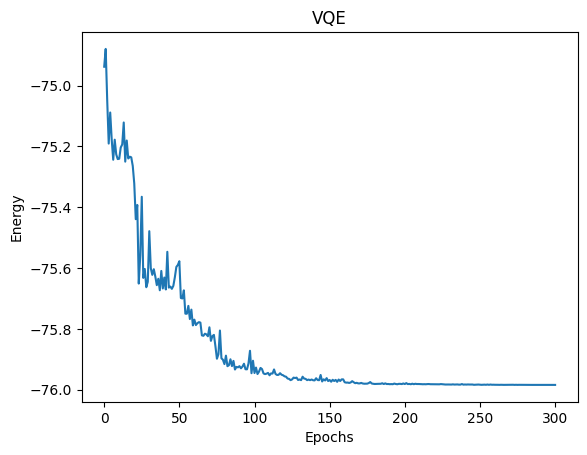

In [3]:
import openfermion
import openfermionpyscf
from openfermion.transforms import jordan_wigner, get_fermion_operator

import timeit


import cudaq
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

# GPU
cudaq.set_target("nvidia-fp64")
# CPU
#cudaq.set_target("qpp-cpu")

# 1- Classical pre-processing:

geometry = [('O', (0.1173,0.0,0.0)), ('H', (-0.4691,0.7570,0.0)), ('H', (-0.4691,-0.7570,0.0))]
basis = '631g'
multiplicity = 1
charge = 0
ncore = 3
norb_cas, nele_cas = (4,4)

molecule = openfermionpyscf.run_pyscf(openfermion.MolecularData(geometry, basis, multiplicity,charge))

molecular_hamiltonian = molecule.get_molecular_hamiltonian(
        occupied_indices=range(ncore), active_indices=range(ncore, ncore + norb_cas))

fermion_hamiltonian = get_fermion_operator(molecular_hamiltonian)
qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

spin_ham = cudaq.SpinOperator(qubit_hamiltonian)

# 2- Quantum computing using UCCSD ansatz

electron_count = nele_cas
qubit_count = 2*norb_cas

@cudaq.kernel
def kernel(qubit_num:int, electron_num:int, thetas: list[float]):
        qubits = cudaq.qvector(qubit_num)

        for i in range(electron_num):
                x(qubits[i])

        cudaq.kernels.uccsd(qubits, thetas, electron_num, qubit_num)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,qubit_count)

# Define a function to minimize
def cost(theta):

        exp_val = cudaq.observe(kernel, spin_ham, qubit_count, electron_count, theta).expectation()

        return exp_val


exp_vals = []

def callback(xk):
        exp_vals.append(cost(xk))

# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, 1, parameter_count)

# Use the scipy optimizer to minimize the function of interest
start_time = timeit.default_timer()
result = minimize(cost, x0, method='COBYLA', callback=callback, options={'maxiter': 300})
end_time = timeit.default_timer()

print('UCCSD-VQE energy =  ', result.fun)
print('Pyscf-CCSD energy = ', mycc.e_tot)
print('Total number of qubits = ', qubit_count)
print('Total number of parameters = ', parameter_count)
print('Total number of terms in the spin hamiltonian = ',spin_ham.get_term_count())
print('Total elapsed time (s) = ', end_time-start_time)

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()